In [1]:
# pip install supervision
# ! pip install opencv-python
# apt-get update

# OpenCV 관련 시스템 라이브러리 설치
# apt-get install -y libgl1-mesa-glx
# !apt-get install -y libglib2.0-0

Using device: cuda
Detected 1 faces


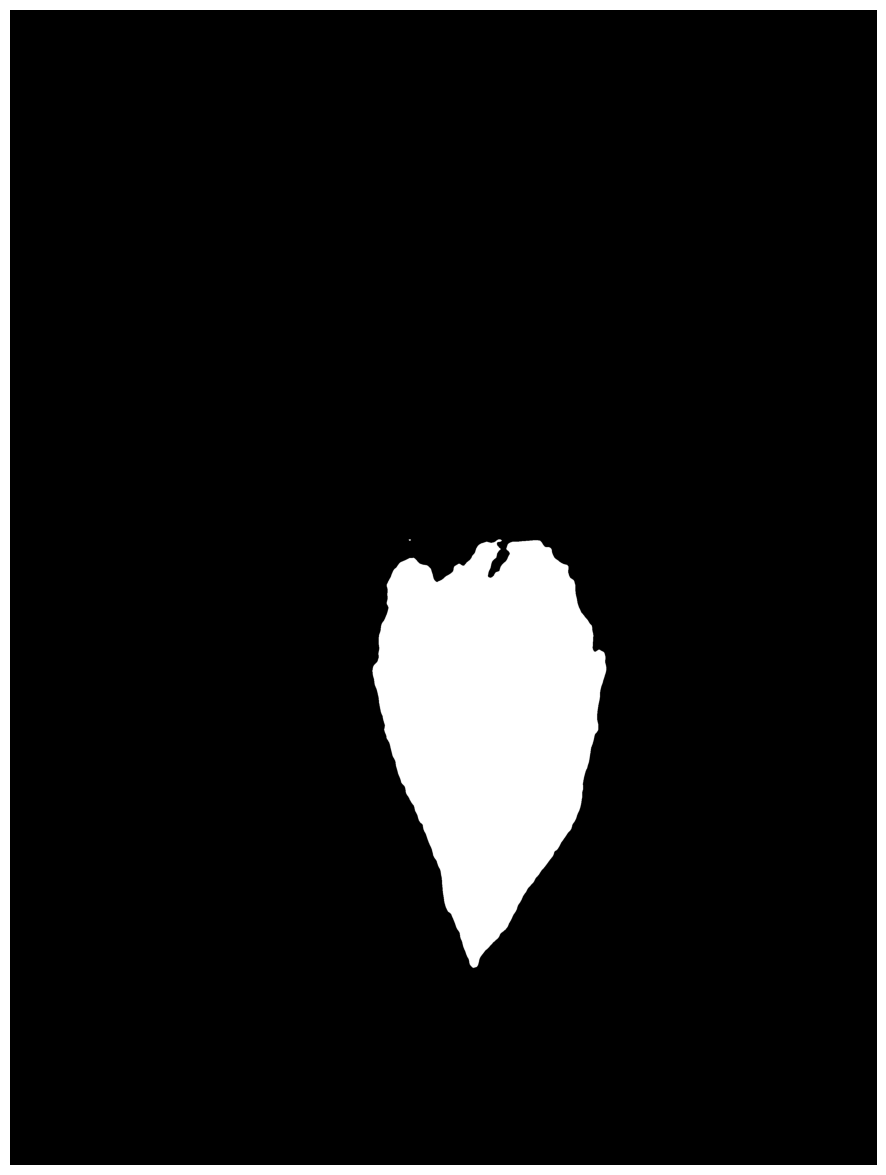

In [1]:
import boto3
import numpy as np
import torch
import cv2
from segment_anything import sam_model_registry, SamPredictor
import matplotlib.pyplot as plt

class FaceDetectorSAM:
   def __init__(self, checkpoint_path: str, model_type: str = "vit_h", device: str = "cuda"):
       self.device = torch.device(device if torch.cuda.is_available() and device == "cuda" else "cpu")
       print(f"Using device: {self.device}")
       
       # SAM 모델 초기화
       self.sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
       self.sam.to(device=self.device)
       self.predictor = SamPredictor(self.sam)
       
       # AWS Rekognition 클라이언트 초기화
       self.rekognition = boto3.client('rekognition')
       
   def detect_faces(self, image: np.ndarray):
       # 이미지를 JPEG 형식으로 인코딩
       _, buffer = cv2.imencode('.jpg', image)
       image_bytes = buffer.tobytes()
       
       # Rekognition으로 얼굴 검출
       response = self.rekognition.detect_faces(
           Image={'Bytes': image_bytes},
           Attributes=['DEFAULT']
       )
       
       if not response['FaceDetails']:
           print("No faces detected by Rekognition")
           return []
       
       # RGB 변환 및 SAM 이미지 설정
       rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
       self.predictor.set_image(rgb_image)
       
       face_masks = []
       for face in response['FaceDetails']:
           bbox = face['BoundingBox']
           # Rekognition은 상대적 좌표(0~1)를 반환하므로 실제 픽셀 좌표로 변환
           image_height, image_width = image.shape[:2]
           
           # 바운딩 박스 확장 (얼굴 주변 영역 포함)
           padding_w = bbox['Width'] * 0.3  # 30% 패딩
           padding_h = bbox['Height'] * 0.3
           
           x1 = max(0, int((bbox['Left'] - padding_w) * image_width))
           y1 = max(0, int((bbox['Top'] - padding_h) * image_height))
           width = min(int((bbox['Width'] + 2 * padding_w) * image_width), image_width - x1)
           height = min(int((bbox['Height'] + 2 * padding_h) * image_height), image_height - y1)
           
           # 얼굴의 주요 특징점들을 포함하도록 여러 점 추가
           center_points = []
           # 중심점
           center_x = x1 + width // 2
           center_y = y1 + height // 2
           center_points.append([center_x, center_y])
           
           # 눈, 코, 입 주변 영역을 커버하는 추가 점들
           points = [
               [center_x, center_y],  # 중심
               [center_x - width//4, center_y - height//4],  # 왼쪽 눈 영역
               [center_x + width//4, center_y - height//4],  # 오른쪽 눈 영역
               [center_x, center_y + height//4],  # 코/입 영역
               [center_x - width//3, center_y],  # 왼쪽 귀 영역
               [center_x + width//3, center_y],  # 오른쪽 귀 영역
               [center_x, center_y - height//3],  # 이마 영역
               [center_x, center_y + height//3]   # 턱 영역
           ]
           
           point_coords = np.array(points)
           point_labels = np.ones(len(points))
           
           # SAM으로 마스크 생성
           masks, scores, _ = self.predictor.predict(
               point_coords=point_coords,
               point_labels=point_labels,
               multimask_output=True,
               box=np.array([x1, y1, x1 + width, y1 + height])
           )
           
           # 가장 적절한 마스크 선택 (중간 크기의 마스크 선택)
           if len(masks) > 0:
               mask_sizes = [np.sum(mask) for mask in masks]
               sorted_indices = np.argsort(mask_sizes)
               best_mask_idx = sorted_indices[len(sorted_indices)//2]  # 중간 크기의 마스크 선택
               
               # 마스크 크기가 적절한 범위 내에 있는지 확인
               mask_area = mask_sizes[best_mask_idx]
               total_area = image_height * image_width
               if 0.01 < mask_area/total_area < 0.15:  # 전체 이미지의 1%~15% 사이
                   face_masks.append(masks[best_mask_idx])
       
       return face_masks

   def visualize_detections(self, image: np.ndarray, masks: list, save_path: str = None):
       # 전체 이미지 크기의 검은색 마스크 생성
       combined_mask = np.zeros((*image.shape[:2], 3), dtype=np.uint8)
       
       # 얼굴 영역만 흰색으로 설정
       for mask in masks:
           combined_mask[mask] = [255, 255, 255]  # 흰색
           
       # 마스크 저장
       if save_path:
           cv2.imwrite(save_path, combined_mask)
           
       # 시각화
       plt.figure(figsize=(15, 15))
       plt.imshow(combined_mask)
       plt.axis('off')
       plt.show()

# 사용하기
CHECKPOINT_PATH = "model/sam_vit_h_4b8939.pth"
detector = FaceDetectorSAM(CHECKPOINT_PATH)

# 이미지 로드
# image_path = "input_image/painter.jpeg"
image_path = "input_image/gonsoo_fall.jpg"
image = cv2.imread(image_path)
if image is None:
   raise ValueError(f"Could not load image from {image_path}")

# 얼굴 감지
face_masks = detector.detect_faces(image)
print(f"Detected {len(face_masks)} faces")

# 결과 시각화 및 저장
detector.visualize_detections(image, face_masks, "output_face_detection.jpg")